## Table of Contents
* [Load S3 image](#Load-S3-image)
* [Show ratio1 band](#Show-ratio1-band)
* [Load the model and make predictions on the S3 image](#Load-the-model-and-make-predictions-on-the-S3-image)
* [Make standard deviation preds with GPR model](#Make-standard-deviation-preds-with-GPR-model)
* [Save preds to `envi`](#Save-preds-to-envi)

In [1]:
from ml import cdom_processing
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from ml import data_load
from imp import reload

## Load S3 image 

In [21]:
!ls /media/disk/databases/C2X/S3Images/

S3A_OL_1_EFR____20170708T084007_20170708T084307_20170709T132811_0179_019_335_1979_MAR_O_NT_002.SEN3
S3A_OL_1_EFR____20170722T091731_20170722T092031_20170723T143757_0180_020_150_1979_MAR_O_NT_002.SEN3
S3A_OL_1_EFR____20170722T091731_20170722T092031_20170723T143757_0180_020_150_1979_MAR_O_NT_002.SEN3_C2RCC.data
S3A_OL_2_WFR____20170722T091731_20170722T092031_20170723T165512_0180_020_150_1979_MAR_O_NT_002.data
S3A_OL_2_WFR____20170722T091731_20170722T092031_20170723T165512_0180_020_150_1979_MAR_O_NT_002.SEN3
subset_0_of_S3A_OL_1_EFR____20160524T090953_20160524T091153_20170930T000736_0119_004_264______MR1_R_NT_002.data
subset_0_of_S3A_OL_1_EFR____20160524T090953_20160524T091153_20170930T000736_0119_004_264______MR1_R_NT_002.dim
subset_0_of_S3A_OL_1_EFR____20170707T090618_20170707T090918_20170708T141329_0179_019_321_1979_MAR_O_NT_002.data
subset_0_of_S3A_OL_1_EFR____20170707T090618_20170707T090918_20170708T141329_0179_019_321_1979_MAR_O_NT_002.dim
subset_0_of_S3A_OL_1_EFR____20170707T090618

In [2]:
reload(cdom_processing)
#s3image_path = "/media/disk/databases/C2X/S3Images/subset_0_of_S3A_OL_2_WFR____20170708T084007_20170708T084307_20170708T104714_0179_019_335_1979_MAR_O_NR_002.data"
s3image_path = "/home/ana/mlregocean/S3OLCI/S3A_OL_1_EFR____20160524T090953_20160524T091153_20170930T000736_0119_004_264______MR1_R_NT_002.SEN3_C2RCC.data"
img = cdom_processing.load_S3_image_C2RCC(image_path=s3image_path)
img.shape


/home/ana/mlregocean/ml/cdom_processing.py:141: RuntimeWarning: divide by zero encountered in true_divide
  S3ratio1 = (images[7]) / (images[3])
/home/ana/mlregocean/ml/cdom_processing.py:141: RuntimeWarning: invalid value encountered in true_divide
  S3ratio1 = (images[7]) / (images[3])
/home/ana/mlregocean/ml/cdom_processing.py:142: RuntimeWarning: divide by zero encountered in true_divide
  S3ratio2 = (images[10]) / (images[3])
/home/ana/mlregocean/ml/cdom_processing.py:142: RuntimeWarning: invalid value encountered in true_divide
  S3ratio2 = (images[10]) / (images[3])


(2728, 4865, 18)

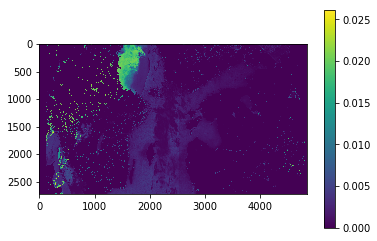

In [4]:

plt.imshow(img[:,:,0])# plt.imshow(img[:,:,0])
plt.colorbar()
plt.show()


## Load and show water mask

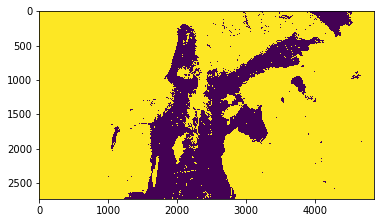

In [7]:
reload(cdom_processing)
mascara = cdom_processing.load_mask_C2RCC(s3image_path)
mascara = (mascara==1)
plt.imshow(mascara)
plt.show()

## Show ratio1 band
[Table of Contents](#Table-of-Contents)

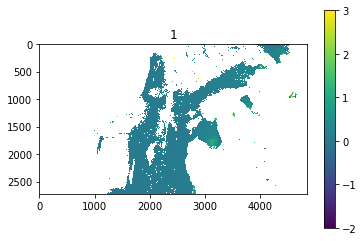

In [8]:
ratio = np.ma.masked_array(img[:,:,17],mascara)
plt.imshow(ratio,vmin=-2,vmax=3)
plt.colorbar()
_ = plt.title(cdom_processing.BAND_NAMES_S3_RATIOS_C2RCC[0])
plt.show()
plt.close()


## Load the model and make predictions on the S3 image
[Table of Contents](#Table-of-Contents)

In [19]:
# Load the model
name_model = "GPR"
bands_name = "S3bands"

def load_model(name_model,bands_name):
    file_model = os.path.join(data_load.PATH_TO_MODELS_C2X,
                              "CDOM_"+name_model+'_'+bands_name+'.pkl')
    return joblib.load(file_model)

regressor_sklearn = load_model(name_model,bands_name)
regressor_sklearn

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('gaussianprocessregressor', GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=1e-05),
             n_restarts_optimizer=4, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None))])

In [20]:
# Select the bands of the image to predict
reload(cdom_processing)
image_predict = cdom_processing.image_to_predict_S3_C2RCC(img,data_load.bands_try_C2X[bands_name])
image_predict.shape

(2728, 4865, 15)

In [21]:
# Load training data to add the mean and compute the min,max range of the predicted variable
reload(cdom_processing)
_, _, skdata_y_train, _ = data_load.load_C2X()
skdata_y_train = skdata_y_train["a_440_cdom"].values

mean_y_train = np.mean(skdata_y_train)
max_cdom = np.max(skdata_y_train)
predictions = cdom_processing.predict_image(image_predict,
                                            mascara,
                                            regressor_sklearn,
                                            y_range=(0,max_cdom),
                                            y_mean=mean_y_train,step=300)
#                                             y_mean=0,step=300)
                                            
predictions.shape


(2728, 4865)

In [26]:
!pwd

/home/ana/mlregocean


In [16]:
max_cdom,mean_y_train

(10.0, 0.7805888689407541)

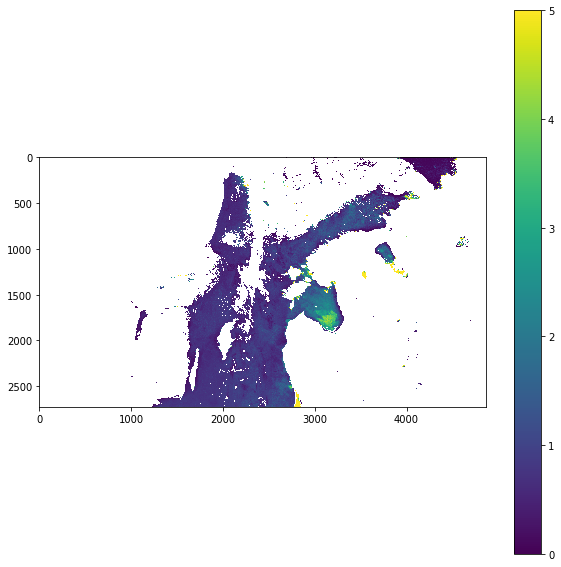

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(predictions,vmin=0,vmax=5)
plt.colorbar()
plt.show()

In [22]:
folder_save = "."
cdom_processing.write_envi(predictions, os.path.join(folder_save,
                                                         name_model+'_'+bands_name+'_CDOM_C2X_20160524_C2RCC.hdr'))
                           


Saving /home/ana/mlregocean/GPR_S3bands_CDOM_C2X_20160524_C2RCC.img


## Make standard deviation preds with GPR model
[Table of Contents](#Table-of-Contents)

In [14]:
if name_model == "GPR":
    min_max_scaler_ = regressor_sklearn.steps[0][1]
    gpr_model_ = regressor_sklearn.steps[1][1]
    predict_function = lambda data: gpr_model_.predict(min_max_scaler_.transform(data),
                                                       return_std=True)[1]
    predictions_std = cdom_processing.predict_image(image_predict,
                                                    mascara,
                                                    predict_function=predict_function,
                                                    y_range=(0,99999),
                                                    y_mean=0,step=300)
    predictions_std.shape


/home/ana/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [ ]:
if name_model == "GPR":
    plt.imshow(predictions_std,vmin=0,vmax=50)
    plt.show()


## Save preds to `envi`
[Table of Contents](#Table-of-Contents)

In [15]:
folder_save = "."
cdom_processing.write_envi(predictions_std, os.path.join(folder_save,
                                                         name_model+'_'+bands_name+'_CDOM_C2X_20160524_err.hdr'))
                           

Saving /home/ana/mlregocean/GPR_S3bands&ratios_CDOM_C2X_20160524_err.img
